In [1]:
import cv2
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras as K
import tensorflow.keras.backend as Kback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load dataset

In [2]:
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.3)   

train_dataset  = train_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)
validation_dataset  = train_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'validation',
                                                   shuffle=True,
                                                   batch_size = 64)


test_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)   

test_dataset  = test_datagen.flow_from_directory(directory = 'D:/RESEARCH/Circuit component recognition/test',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)

Found 4200 images belonging to 20 classes.
Found 1800 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.


# EfficientNetB0

In [3]:
input_layer = K.Input(shape=(160,160,3))
effnet_model = K.applications.EfficientNetB0(include_top = False, weights = "imagenet", input_tensor = input_layer)
for layer in effnet_model.layers[:150]:
    layer.trainable = False
for i, layer in enumerate(effnet_model.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 rescaling - False
2 normalization - False
3 tf.math.truediv - False
4 stem_conv_pad - False
5 stem_conv - False
6 stem_bn - False
7 stem_activation - False
8 block1a_dwconv - False
9 block1a_bn - False
10 block1a_activation - False
11 block1a_se_squeeze - False
12 block1a_se_reshape - False
13 block1a_se_reduce - False
14 block1a_se_expand - False
15 block1a_se_excite - False
16 block1a_project_conv - False
17 block1a_project_bn - False
18 block2a_expand_conv - False
19 block2a_expand_bn - False
20 block2a_expand_activation - False
21 block2a_dwconv_pad - False
22 block2a_dwconv - False
23 block2a_bn - False
24 block2a_activation - False
25 block2a_se_squeeze - False
26 block2a_se_reshape - False
27 block2a_se_reduce - False
28 block2a_se_expand - False
29 block2a_se_excite - False
30 block2a_project_conv - False
31 block2a_project_bn - False
32 block2b_expand_conv - False
33 block2b_expand_bn - False
34 block2b_expand_activation - False
35 block2b_dwconv - False
36

In [4]:
METRICS = [
      K.metrics.BinaryAccuracy(name='accuracy'),
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),  
      K.metrics.AUC(name='auc')
]

In [5]:
inputs = K.layers.Input(shape=(160,160,3), name="image")  

resnet50 = effnet_model(inputs)
flat = K.layers.Flatten()(resnet50)
output = K.layers.Dense(20, activation='softmax')(flat)

model = K.Model(inputs=inputs, outputs=output)
optimizer = K.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
model.compile(loss=["categorical_crossentropy"], metrics=METRICS, optimizer = optimizer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 160, 160, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 5, 5, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense (Dense)               (None, 20)                640020    
                                                                 
Total params: 4,689,591
Trainable params: 3,927,724
Non-trainable params: 761,867
_________________________________________________________________


C:\Python\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training

In [6]:
checkpoint_filepath = 'D:/RESEARCH/Circuit component recognition/'
model_checkpoint_callback = K.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(train_dataset,
                    epochs = 25,
                    validation_data = validation_dataset,
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/25
66/66 [==============================] - 237s 3s/step - loss: 4.1895 - accuracy: 0.9449 - precision: 0.0486 - recall: 0.0055 - auc: 0.4988 - val_loss: 3.9014 - val_accuracy: 0.9500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5020
Epoch 2/25
66/66 [==============================] - 230s 3s/step - loss: 3.4527 - accuracy: 0.9495 - precision: 0.2660 - recall: 0.0060 - auc: 0.5391 - val_loss: 6.9700 - val_accuracy: 0.9050 - val_precision: 0.0500 - val_recall: 0.0500 - val_auc: 0.5028
Epoch 3/25
66/66 [==============================] - 230s 4s/step - loss: 2.9339 - accuracy: 0.9494 - precision: 0.4544 - recall: 0.0581 - auc: 0.6783 - val_loss: 13.4946 - val_accuracy: 0.9059 - val_precision: 0.0589 - val_recall: 0.0589 - val_auc: 0.5041
Epoch 4/25
66/66 [==============================] - 229s 3s/step - loss: 2.5684 - accuracy: 0.9509 - precision: 0.5310 - recall: 0.1507 - auc: 0.7754 - val_loss: 15.7785 - val_accuracy: 0.9054 - val_precision: 0.0534 - val_rec

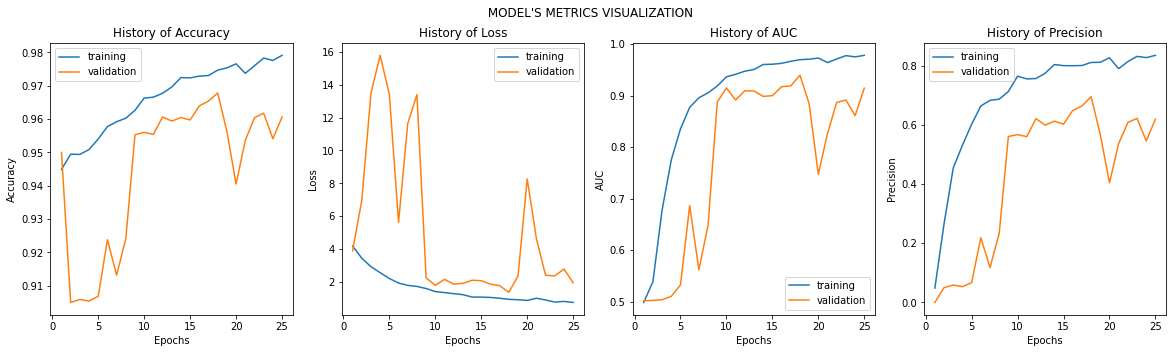

In [7]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
              )

In [8]:
model.save("efficientnetB0.hdf5")

# Testing

In [9]:
# saved last model
model = K.models.load_model("efficientnetB0.hdf5")
model.evaluate(test_dataset)

32/32 [==============================] - 73s 2s/step - loss: 3.7349 - accuracy: 0.9509 - precision: 0.5095 - recall: 0.4575 - auc: 0.8470


[3.7348713874816895,
 0.9508500099182129,
 0.5094654560089111,
 0.45750001072883606,
 0.8470462560653687]

C:\Users\aroy8\AppData\Local\Temp/ipykernel_16396/3580747851.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)
Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1157 batches). You may need to use the repeat() function when building your dataset.


Confusion Matrix


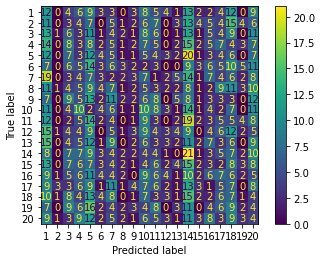

Classification Report
              precision    recall  f1-score   support

           1       0.05      0.12      0.07       100
           2       0.00      0.00      0.00       100
           3       0.06      0.06      0.06       100
           4       0.03      0.03      0.03       100
           5       0.06      0.12      0.08       100
           6       0.06      0.03      0.04       100
           7       0.02      0.02      0.02       100
           8       0.04      0.01      0.02       100
           9       0.05      0.02      0.03       100
          10       0.08      0.10      0.09       100
          11       0.03      0.03      0.03       100
          12       0.09      0.03      0.04       100
          13       0.05      0.02      0.03       100
          14       0.08      0.21      0.12       100
          15       0.06      0.02      0.03       100
          16       0.07      0.06      0.07       100
          17       0.05      0.05      0.05       100
     

In [10]:
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))